---
title: Vulcan Fossil Fuel CO₂ Emissions
description: Annual (2010 - 2021), 1 km resolution estimates of carbon dioxide emissions from fossil fuels and cement production over the contiguous United States, version 4.0.
author: Siddharth Chaudhary, Paridhi Parajuli
date: 30 August 2024
execute:
   freeze: true
---

## Run this notebook

You can launch this notebook in the US GHG Center JupyterHub by clicking the link below.

[Launch in the US GHG Center JupyterHub (requires access)](https://hub.ghg.center/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2FUS-GHG-Center%2Fghgc-docs&urlpath=lab%2Ftree%2Fghgc-docs%2Fuser_data_notebooks%2Fvulcan-ffco2-yeargrid-v4_User_Notebook_User_Notebook.ipynb&branch=main)
   

## Approach

1. Identify available dates and temporal frequency of observations for the given collection using the GHGC API `/stac` endpoint. The collection processed in this notebook is the Vulcan Fossil Fuel CO₂ Emissions Data product.
2. Pass the STAC item into the raster API `/collections/{collection_id}/items/{item_id}/tilejson.json` endpoint.
3. Using `folium.plugins.DualMap`, we will visualize two tiles (side-by-side), allowing us to compare time points. 
4. After the visualization, we will perform zonal statistics for a given polygon.

   

## About the Data

The Vulcan version 4.0 data product represents total carbon dioxide (CO2) emissions resulting from the combustion of fossil fuel (ff) for the contiguous United States and District of Columbia. Referred to as ffCO2, the emissions from Vulcan are also categorized into 10 source sectors including; airports, cement production, commercial marine vessels, commercial, power plants, industrial, non-road, on-road, residential and railroads. Data are gridded annually on a 1-km grid for the years 2010 to 2021. These data are annual sums of hourly estimates. Shown is the estimated total annual ffCO2 for the United States, as well as the estimated total annual ffCO2 per sector.

For more information regarding this dataset, please visit the [Vulcan Fossil Fuel CO₂ Emissions, Version 4](https://earth.gov/ghgcenter/data-catalog/vulcan-ffco2-yeargrid-v4) data overview page.

# Install the Required Libraries
Required libraries are pre-installed on the GHG Center Hub. If you need to run this notebook elsewhere, please install them with this line in a code cell:

%pip install requests folium rasterstats pystac_client pandas matplotlib --quiet

In [1]:
import requests
import folium
import folium.plugins
from folium import Map, TileLayer 
from pystac_client import Client 
import branca 
import pandas as pd
import matplotlib.pyplot as plt

/Users/rrimal/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Querying the STAC API
First, we are going to import the required libraries. Once imported, they allow better executing a query in the GHG Center Spatio Temporal Asset Catalog (STAC) Application Programming Interface (API) where the granules for this collection are stored.

In [2]:
# Provide STAC and RASTER API endpoints
STAC_API_URL = "https://earth.gov/ghgcenter/api/stac"
RASTER_API_URL = "https://earth.gov/ghgcenter/api/raster"

# Please use the collection name similar to the one used in the STAC collection.
# Name of the collection for Vulcan Fossil Fuel CO₂ Emissions, Version 4. 
collection_name = "vulcan-ffco2-yeargrid-v4"

In [3]:
# Fetch the collection from STAC collections using the appropriate endpoint
# the 'requests' library allows a HTTP request possible
collection_vulcan = requests.get(f"{STAC_API_URL}/collections/{collection_name}").json()


Examining the contents of our `collection` under the `temporal` variable, we see that the data is available from January 2010 to December 2021. By looking at the `dashboard:time density`, we observe that the data is periodic with year time density.

In [4]:
collection_vulcan

{'id': 'vulcan-ffco2-yeargrid-v4',
 'type': 'Collection',
 'links': [{'rel': 'items',
   'type': 'application/geo+json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/vulcan-ffco2-yeargrid-v4/items'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/'},
  {'rel': 'self',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/vulcan-ffco2-yeargrid-v4'}],
 'title': 'Vulcan Fossil Fuel CO₂ Emissions v4.0',
 'extent': {'spatial': {'bbox': [[-128.22654896758996,
     22.857766529124284,
     -65.30917199495289,
     51.44087947724907]]},
  'temporal': {'interval': [['2010-01-01 00:00:00+00',
     '2021-12-31 00:00:00+00']]}},
 'license': 'CC-BY-NC-4.0',
 'renders': {'air-co2': {'assets': ['air-co2'],
   'rescale': [[0, 500]],
   'colormap_name': 'spectral_r'},
  'cmt-co2': {'assets': ['cmt

In [5]:
# Create a function that would search for the above data collection in the STAC API
def get_item_count(collection_id):
    count = 0
    items_url = f"{STAC_API_URL}/collections/{collection_id}/items"

    while True:
        response = requests.get(items_url)

        if not response.ok:
            print("error getting items")
            exit()

        stac = response.json()
        count += int(stac["context"].get("returned", 0))
        next = [link for link in stac["links"] if link["rel"] == "next"]

        if not next:
            break
        items_url = next[0]["href"]

    return count

In [6]:
# Apply the above function and check the total number of items available within the collection
number_of_items = get_item_count(collection_name)
items_vulcan = requests.get(f"{STAC_API_URL}/collections/{collection_name}/items?limit={number_of_items}").json()["features"]
print(f"Found {len(items_vulcan)} items")

Found 12 items


In [7]:
# Examine the first item in the collection
# Keep in mind that a list starts from 0, 1, 2... therefore items[0] is referring to the first item in the list/collection
items_vulcan[0]

{'id': 'vulcan-ffco2-yeargrid-v4-2021',
 'bbox': [-128.22654896758996,
  22.857766529124284,
  -65.30917199495289,
  51.44087947724907],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/vulcan-ffco2-yeargrid-v4'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/vulcan-ffco2-yeargrid-v4'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/vulcan-ffco2-yeargrid-v4/items/vulcan-ffco2-yeargrid-v4-2021'},
  {'title': 'Map of Item',
   'href': 'https://earth.gov/ghgcenter/api/raster/collections/vulcan-ffco2-yeargrid-v4/items/vulcan-ffco2-yeargrid-v4-2021/map?assets=total-co2&rescale=0%2C500&colormap_name=spectral_r',
   'rel': 'preview',
   'type': 'text/html'}],
 'assets

In [8]:
# To access the year value from each item more easily, this will let us query more explicitly by year and month (e.g., 2020-02)
items = {item["properties"]["start_datetime"][:4]: item for item in items_vulcan} 
# rh = Heterotrophic Respiration
asset_name = "total-co2"

In [9]:
rescale_values = {"max":items[list(items.keys())[0]]["assets"][asset_name]["raster:bands"][0]["histogram"]["max"], "min":items[list(items.keys())[0]]["assets"][asset_name]["raster:bands"][0]["histogram"]["min"]}

Now, we will pass the item id, collection name, asset name, and the `rescaling factor` to the `Raster API` endpoint. We will do this twice, once for 2021 and again for 2010, so that we can visualize each event independently.

In [10]:
color_map = "spectral_r" # please refer to matplotlib library if you'd prefer choosing a different color ramp.
# For more information on Colormaps in Matplotlib, please visit https://matplotlib.org/stable/users/explain/colors/colormaps.html

# To change the year and month of the observed parameter, you can modify the "items['YYYY-MM']" statement
# For example, you can change the current statement "items['2003-12']" to "items['2016-10']" 
_2021_tile = requests.get(
    f"{RASTER_API_URL}/collections/{items['2021']['collection']}/items/{items['2021']['id']}/tilejson.json?"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale=0,150", 
).json()
_2021_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://earth.gov/ghgcenter/api/raster/collections/vulcan-ffco2-yeargrid-v4/items/vulcan-ffco2-yeargrid-v4-2021/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?assets=total-co2&color_formula=gamma+r+1.05&colormap_name=spectral_r&rescale=0%2C150'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-128.22654896758996,
  22.857766529124284,
  -65.30917199495289,
  51.44087947724907],
 'center': [-96.76786048127143, 37.14932300318668, 0]}

In [11]:
_2010_tile = requests.get(
    f"{RASTER_API_URL}/collections/{items['2010']['collection']}/items/{items['2010']['id']}/tilejson.json?"

    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale=0,150", 
).json()
_2010_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://earth.gov/ghgcenter/api/raster/collections/vulcan-ffco2-yeargrid-v4/items/vulcan-ffco2-yeargrid-v4-2010/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?assets=total-co2&color_formula=gamma+r+1.05&colormap_name=spectral_r&rescale=0%2C150'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-128.22654896758996,
  22.857766529124284,
  -65.30917199495289,
  51.44087947724907],
 'center': [-96.76786048127143, 37.14932300318668, 0]}

## Visualizing Total Fossil Fuel CO₂ Emissions

In [12]:
map_ = folium.plugins.DualMap(location=(34, -118), zoom_start=6)


# Define the first map layer with the CO2 Flux data for December 2022
map_layer_2021 = TileLayer(
    tiles=_2021_tile["tiles"][0], # Path to retrieve the tile
    attr="GHG", # Set the attribution 
    name='2021 Total CO2 Fossil Fuel Emissions', # Title for the layer
    overlay=True, # The layer can be overlaid on the map
    opacity=0.8, # Adjust the transparency of the layer
)
# Add the first layer to the Dual Map 
map_layer_2021.add_to(map_.m1)

map_layer_2010 = TileLayer(
    tiles=_2010_tile["tiles"][0], # Path to retrieve the tile
    attr="GHG", # Set the attribution 
    name='2010 Total CO2 Fossil Fuel Emissions', # Title for the layer
    overlay=True, # The layer can be overlaid on the map
    opacity=0.8, # Adjust the transparency of the layer
)
# Add the first layer to the Dual Map 
map_layer_2010.add_to(map_.m2)

map_

# Calculating Zonal Statistics
To perform zonal statistics, first we need to create a polygon. In this use case we are creating a polygon in Texas (USA).

In [13]:
# Create a polygon for the area of interest (aoi)
texas_aoi = {
    "type": "Feature", # Create a feature object
    "properties": {},
    "geometry": { # Set the bounding coordinates for the polygon
        "coordinates": [
            [
                [-95, 29], # South-east bounding coordinate
                [-95, 33], # North-east bounding coordinate
                [-104,33], # North-west bounding coordinate
                [-104,29], # South-west bounding coordinate
                [-95, 29]  # South-east bounding coordinate (closing the polygon)
            ]
        ],
        "type": "Polygon",
    },
}

In [14]:
# Create a new map to display the generated polygon
# We'll plug in the coordinates for a location
# Central to the study area and a reasonable zoom level
aoi_map = Map(

    # Base map is set to OpenStreetMap
    tiles="OpenStreetMap",

    # Define the spatial properties for the map
    location=[
        30,-100
    ],

    # Set the zoom value
    zoom_start=6,
)

# Insert the polygon to the map
folium.GeoJson(texas_aoi, name="Texas, USA").add_to(aoi_map)

# Visualize the map
aoi_map

In [15]:
# Check total number of items available within the collection
items = requests.get(
    f"{STAC_API_URL}/collections/{collection_name}/items?limit=600"
).json()["features"]

# Print the total number of items (granules) found
print(f"Found {len(items)} items")

Found 12 items


In [16]:
# Examine the first item in the collection
items[0]

{'id': 'vulcan-ffco2-yeargrid-v4-2021',
 'bbox': [-128.22654896758996,
  22.857766529124284,
  -65.30917199495289,
  51.44087947724907],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/vulcan-ffco2-yeargrid-v4'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/vulcan-ffco2-yeargrid-v4'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/vulcan-ffco2-yeargrid-v4/items/vulcan-ffco2-yeargrid-v4-2021'},
  {'title': 'Map of Item',
   'href': 'https://earth.gov/ghgcenter/api/raster/collections/vulcan-ffco2-yeargrid-v4/items/vulcan-ffco2-yeargrid-v4-2021/map?assets=total-co2&rescale=0%2C500&colormap_name=spectral_r',
   'rel': 'preview',
   'type': 'text/html'}],
 'assets

Now that we created the polygon for the area of interest, we need to develop a function that runs through the data collection and generates the statistics for a specific item (granule) within the boundaries of the AOI polygon.

In [17]:
# The bounding box should be passed to the geojson param as a geojson Feature or FeatureCollection
# Create a function that retrieves information regarding a specific granule using its asset name and raster identifier and generates the statistics for it

# The function takes an item (granule) and a JSON (polygon) as input parameters
def generate_stats(item, geojson):

    # A POST request is made to submit the data associated with the item of interest (specific observation) within the boundaries of the polygon to compute its statistics
    result = requests.post(

        # Raster API Endpoint for computing statistics
        f"{RASTER_API_URL}/cog/statistics",

        # Pass the URL to the item, asset name, and raster identifier as parameters
        params={"url": item["assets"][asset_name]["href"]},

        # Send the GeoJSON object (polygon) along with the request
        json=geojson,

    # Return the response in JSON format
    ).json()

    # Print the result
    print(result)

    # Return a dictionary containing the computed statistics along with the item's datetime information.
    return {
        **result["properties"],
        "datetime": item["properties"]["start_datetime"][:10],
    }

In [18]:
# Generate a for loop that iterates over all the existing items in the collection
for item in items:

    # The loop will then retrieve the information for the start datetime of each item in the list
    print(item["properties"]["start_datetime"][:10])

    # Exit the loop after printing the start datetime for the first item in the collection
    break

2021-01-01


With the function above we can generate the statistics for the AOI.

In [19]:
%%time
# %%time = Wall time (execution time) for running the code below

# Generate statistics using the created function "generate_stats" within the bounding box defined by the polygon
stats = [generate_stats(item, texas_aoi) for item in items]

{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[-95.0, 29.0], [-95.0, 33.0], [-104.0, 33.0], [-104.0, 29.0], [-95.0, 29.0]]]}, 'properties': {'statistics': {'b1': {'min': 1.7858106104995386e-07, 'max': 3768974.0, 'mean': 261.6907958984375, 'count': 296120.0625, 'sum': 77491896.0, 'std': 11522.940944047226, 'median': 7.39058256149292, 'majority': 0.19903208315372467, 'minority': 1.7858106104995386e-07, 'unique': 242084.0, 'histogram': [[296498.0, 13.0, 6.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 2.0], [1.7858106104995386e-07, 376897.40625, 753794.8125, 1130692.25, 1507589.625, 1884487.0, 2261384.5, 2638281.75, 3015179.25, 3392076.75, 3768974.0]], 'valid_percent': 95.72, 'masked_pixels': 13265.0, 'valid_pixels': 296520.0, 'percentile_2': 0.20036202669143677, 'percentile_98': 1811.0848388671875}}}}
{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[-95.0, 29.0], [-95.0, 33.0], [-104.0, 33.0], [-104.0, 29.0], [-95.0, 29.0]]]}, 'properties': {'statistics': {'

Create a function that goes through every single item in the collection and populates their properties - including the minimum, maximum, and sum of their values - in a table.

In [20]:
# Print the stats for the first item in the collection
stats[0]

{'statistics': {'b1': {'min': 1.7858106104995386e-07,
   'max': 3768974.0,
   'mean': 261.6907958984375,
   'count': 296120.0625,
   'sum': 77491896.0,
   'std': 11522.940944047226,
   'median': 7.39058256149292,
   'majority': 0.19903208315372467,
   'minority': 1.7858106104995386e-07,
   'unique': 242084.0,
   'histogram': [[296498.0, 13.0, 6.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 2.0],
    [1.7858106104995386e-07,
     376897.40625,
     753794.8125,
     1130692.25,
     1507589.625,
     1884487.0,
     2261384.5,
     2638281.75,
     3015179.25,
     3392076.75,
     3768974.0]],
   'valid_percent': 95.72,
   'masked_pixels': 13265.0,
   'valid_pixels': 296520.0,
   'percentile_2': 0.20036202669143677,
   'percentile_98': 1811.0848388671875}},
 'datetime': '2021-01-01'}

In [21]:
# Create a function that converts statistics in JSON format into a pandas DataFrame
def clean_stats(stats_json) -> pd.DataFrame:

    # Normalize the JSON data
    df = pd.json_normalize(stats_json)

    # Replace the naming "statistics.b1" in the columns
    df.columns = [col.replace("statistics.b1.", "") for col in df.columns]

    # Set the datetime format
    df["date"] = pd.to_datetime(df["datetime"])

    # Return the cleaned format
    return df

# Apply the generated function on the stats data
df = clean_stats(stats)

# Display the stats for the first 5 granules in the collection in the table
# Change the value in the parenthesis to show more or a smaller number of rows in the table
df.head(5)

,datetime,min,max,mean,count,sum,std,median,majority,minority,unique,histogram,valid_percent,masked_pixels,valid_pixels,percentile_2,percentile_98,date
0,2021-01-01,1.785811e-07,3768974.0,261.690796,296120.0625,77491896.0,11522.940944,7.390583,0.199032,1.785811e-07,242084.0,"[[296498.0, 13.0, 6.0, 0.0, 1.0, 0.0, 0.0, 0.0...",95.72,13265.0,296520.0,0.200362,1811.084839,2021-01-01
1,2020-01-01,1.622880e-07,3548930.5,254.962936,296120.0625,75499640.0,10912.768301,6.836727,0.180845,1.622880e-07,242118.0,"[[296495.0, 14.0, 6.0, 2.0, 1.0, 0.0, 0.0, 1.0...",95.72,13265.0,296520.0,0.182224,1713.106445,2020-01-01
2,2019-01-01,1.877873e-07,3369803.0,276.884796,296120.0625,81991144.0,11799.911186,7.814598,0.527155,1.877873e-07,242967.0,"[[296495.0, 13.0, 6.0, 3.0, 0.0, 0.0, 0.0, 1.0...",95.72,13265.0,296520.0,0.212244,1882.463623,2019-01-01
3,2018-01-01,1.853067e-07,3868559.5,278.522980,296120.0625,82476240.0,12222.416782,7.711860,0.519930,1.853067e-07,242928.0,"[[296497.0, 14.0, 6.0, 0.0, 0.0, 0.0, 1.0, 0.0...",95.72,13265.0,296520.0,0.208977,1912.632568,2018-01-01
4,2017-01-01,1.802980e-07,4050962.5,271.169403,296120.0625,80298704.0,13290.472377,7.446557,0.505795,1.802980e-07,242922.0,"[[296499.0, 14.0, 3.0, 0.0, 0.0, 1.0, 1.0, 0.0...",95.72,13265.0,296520.0,0.203270,1775.784790,2017-01-01


## Visualizing the Data as a Time Series
We can now explore the total fossil fuel emission time series (2010 -2021) available for the Dallas, Texas area of the U.S. We can plot the data set using the code below:

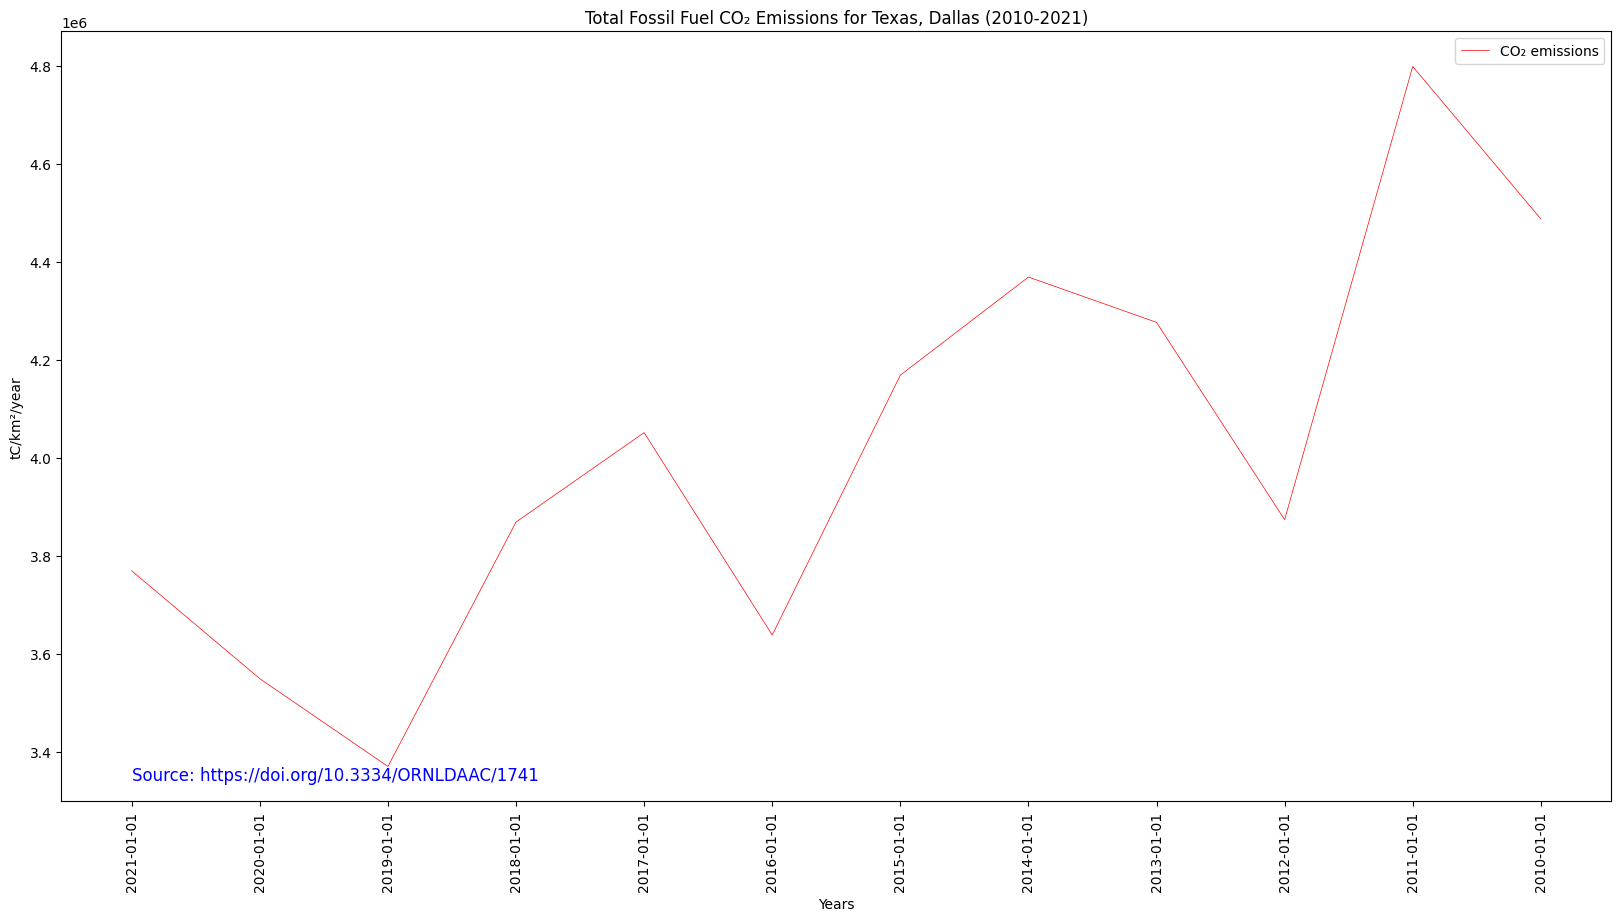

In [22]:
# Figure size: 20 representing the width, 10 representing the height
fig = plt.figure(figsize=(20, 10))

plt.plot(
    df["datetime"], # X-axis: sorted datetime
    df["max"], # Y-axis: maximum CO₂
    color="red", # Line color
    linestyle="-", # Line style
    linewidth=0.5, # Line width
    label="CO₂ emissions", # Legend label
)

# Display legend
plt.legend()

# Insert label for the X-axis
plt.xlabel("Years")

# Insert label for the Y-axis
plt.ylabel("tC/km²/year")
plt.xticks(rotation = 90)

# Insert title for the plot
plt.title("Total Fossil Fuel CO₂ Emissions for Texas, Dallas (2010-2021)")

# Add data citation
plt.text(
    df["datetime"].iloc[0],           # X-coordinate of the text
    df["max"].min(),                  # Y-coordinate of the text




    # Text to be displayed
    "Source: https://doi.org/10.3334/ORNLDAAC/1741",                  
    fontsize=12,                             # Font size
    horizontalalignment="left",              # Horizontal alignment
    verticalalignment="top",                 # Vertical alignment
    color="blue",                            # Text color
)


# Plot the time series
plt.show()

## Summary

In this notebook we have successfully explored, analyzed, and visualized the STAC collection for Vulcan Fossil Fuel CO₂ Emissions, Version 4 dataset.

1.  Install and import the necessary libraries
2.  Fetch the collection from STAC collections using the appropriate endpoints
3.  Count the number of existing granules within the collection
4.  Map and compare the total fossil fuel CO₂ emissions for two distinctive months/years
5.  Generate zonal statistics for the area of interest (AOI)
6.  Visualizing the Data as a Time Series


If you have any questions regarding this user notebook, please contact us using the [feedback form](https://docs.google.com/forms/d/e/1FAIpQLSeVWCrnca08Gt_qoWYjTo6gnj1BEGL4NCUC9VEiQnXA02gzVQ/viewform).